Autor: Anja Delić

Prvi deo zadatka - Ekstrakcija crepa sa slike - fja za ekstrakciju crepa
   - Ulaz: originalna slika crepa
   - Izlaz: nova slika dimenzija 1280x960 sa ekstrahovanim crepom centriranim na crnoj pozadini

Drugi deo zadatka - Klasifikacija kvaliteta - fja za klasifikaciju
   - Poređenje ekstrahovanog crepa sa "idealnim" crepom
   - Provera dva kriterijuma:
     1. Da li je crep odgovarajuće veličine
     2. Da li mu nedostaju delovi
   - Klasifikacija u dve kategorije: "zadovoljavajući" ili "nezadovoljavajući" kvalitet
   - Upisivanje rezultata u CSV fajl sa formatom:
    			 ime_slike_napred, ime_slike_nazad, klasa

In [5]:
# Dodavanje potrebnih biblioteka
import os
import cv2
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import csv
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


Ekstrahovanje crepa

In [7]:
def extract_and_center_tile(image_input, debug=False, output_size=(1280, 960)):
    # Proverava da li je ulaz putanja do slike ili numpy niz
    if isinstance(image_input, str):
        # Ako je ulaz putanja, učitava sliku
        img = cv2.imread(image_input)
        if img is None:
            raise ValueError(f"Ne može se učitati slika: {image_input}")
    elif isinstance(image_input, np.ndarray):
        # Ako je ulaz već slika u obliku numpy niza
        img = image_input
    else:
        raise ValueError("Input mora biti putanja (str) ili numpy array sa slikom")

    # Pretvara sliku iz BGR u HSV prostor boja za lakšu segmentaciju
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Definisanje opsega braon boje u HSV prostoru za maskiranje
    lower_brown = np.array([0, 40, 20])
    upper_brown = np.array([30, 255, 200])
    mask = cv2.inRange(hsv, lower_brown, upper_brown)

    # Primena morfoloških operacija za uklanjanje šuma i popunjavanje rupa u masci
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # Pronalazi konture na osnovu maske
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("Nisu pronađene konture u slici")

    # Pronalazi najveću konturu prema površini
    largest_contour = max(contours, key=cv2.contourArea)

    # Kreira masku i primenjuje je na originalnu sliku
    mask = np.zeros_like(img) # crna maska dimenzije kao originalna slika
    cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)
    masked_tile = cv2.bitwise_and(img, mask)

    # Isecanje dela slike oko najveće konture
    x, y, w, h = cv2.boundingRect(largest_contour)
    tile_cropped = masked_tile[y:y+h, x:x+w]

    # Skaliranje isečene slike uz očuvanje proporcija
    scale = min(output_size[0] / w, output_size[1] / h)
    new_w, new_h = int(w * scale), int(h * scale)
    tile_resized = cv2.resize(tile_cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Centriranje skalirane slike na crnu pozadinu zadatih dimenzija
    output = np.zeros((output_size[1], output_size[0], 3), dtype=np.uint8)
    x_offset = (output_size[0] - new_w) // 2
    y_offset = (output_size[1] - new_h) // 2
    output[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = tile_resized

    # Prikazivanje debug slika ako je debug parametar True
    if debug:
        plt.figure(figsize=(18, 6))
        plt.subplot(141), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.subplot(142), plt.imshow(mask, cmap='gray')
        plt.title("Brown mask")
        plt.subplot(143), plt.imshow(cv2.cvtColor(tile_cropped, cv2.COLOR_BGR2RGB))
        plt.title("Cropped tile")
        plt.subplot(144), plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        plt.title("Final centered")
        plt.tight_layout()
        plt.show()

    # Vraća finalnu centriranu sliku
    return output

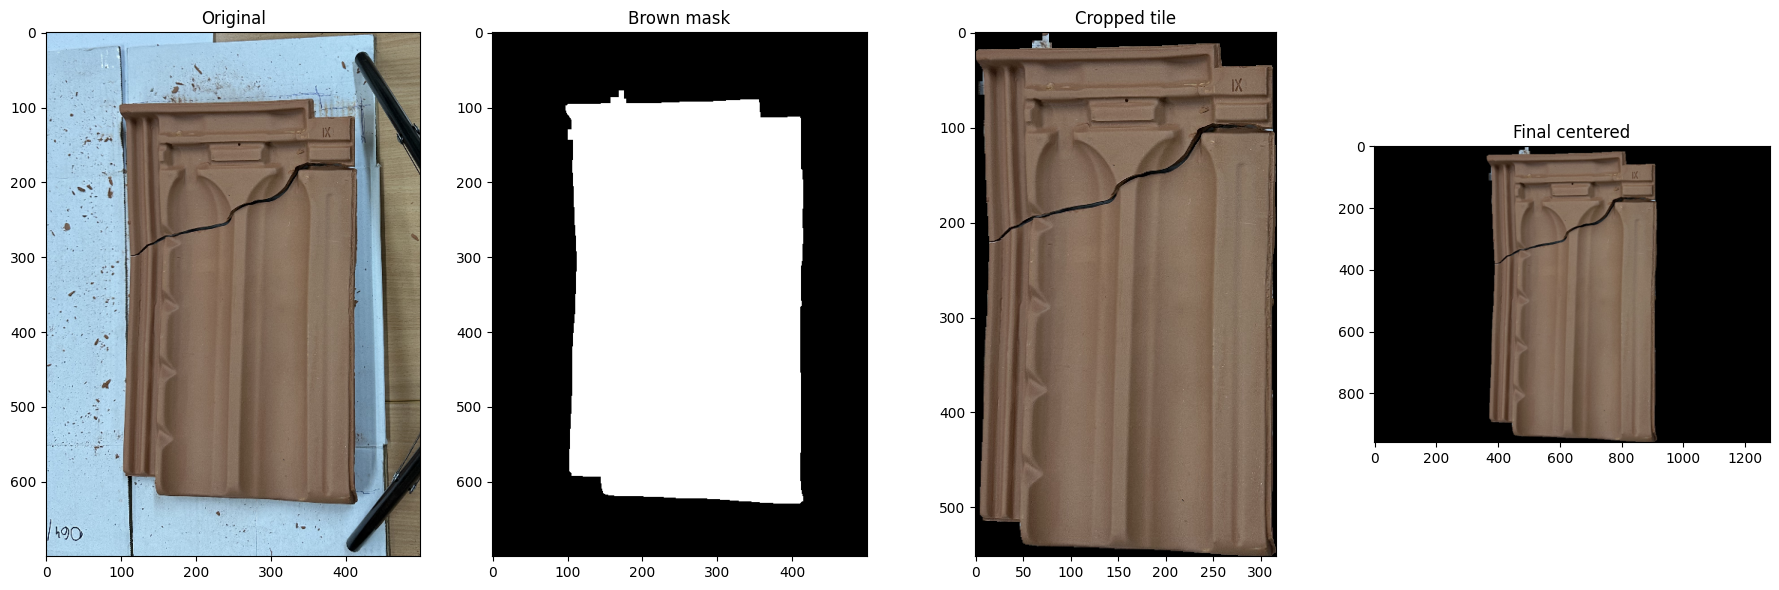

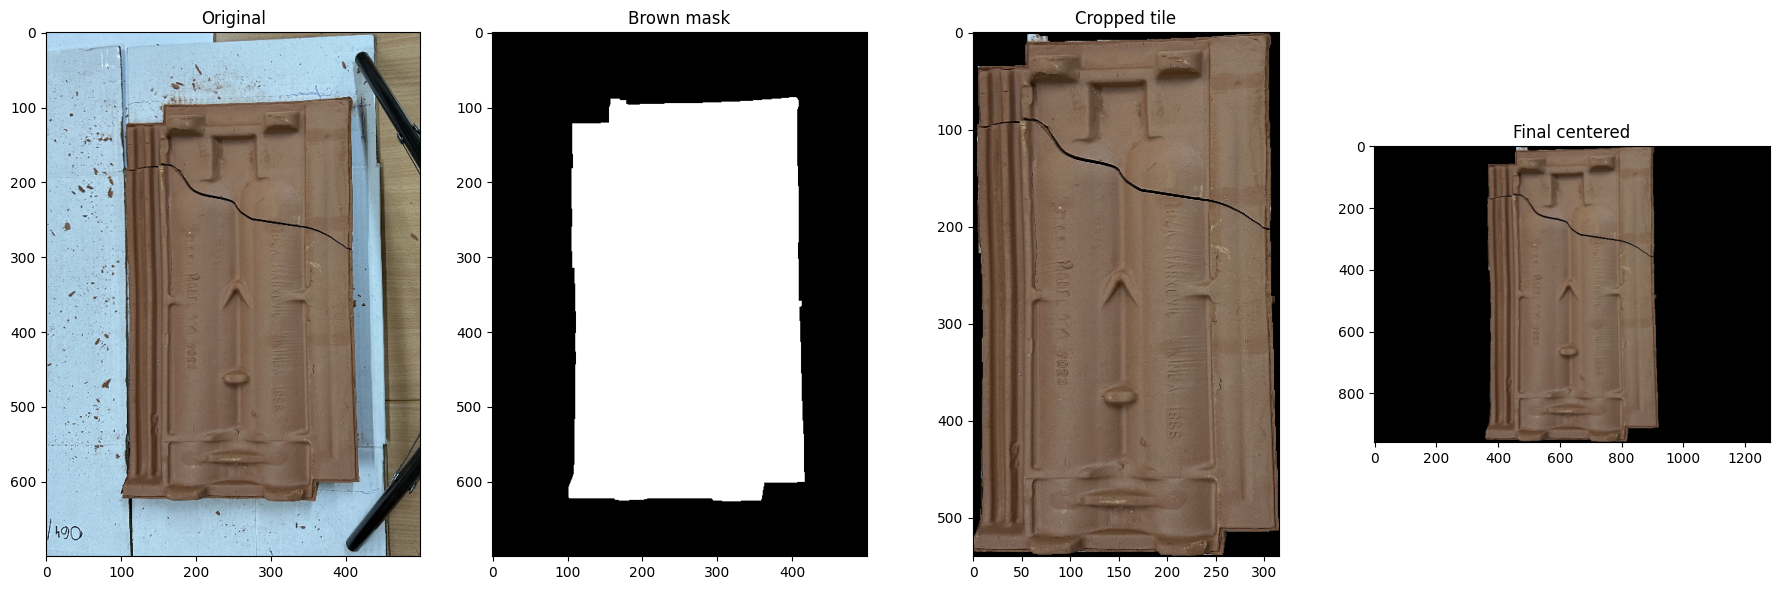

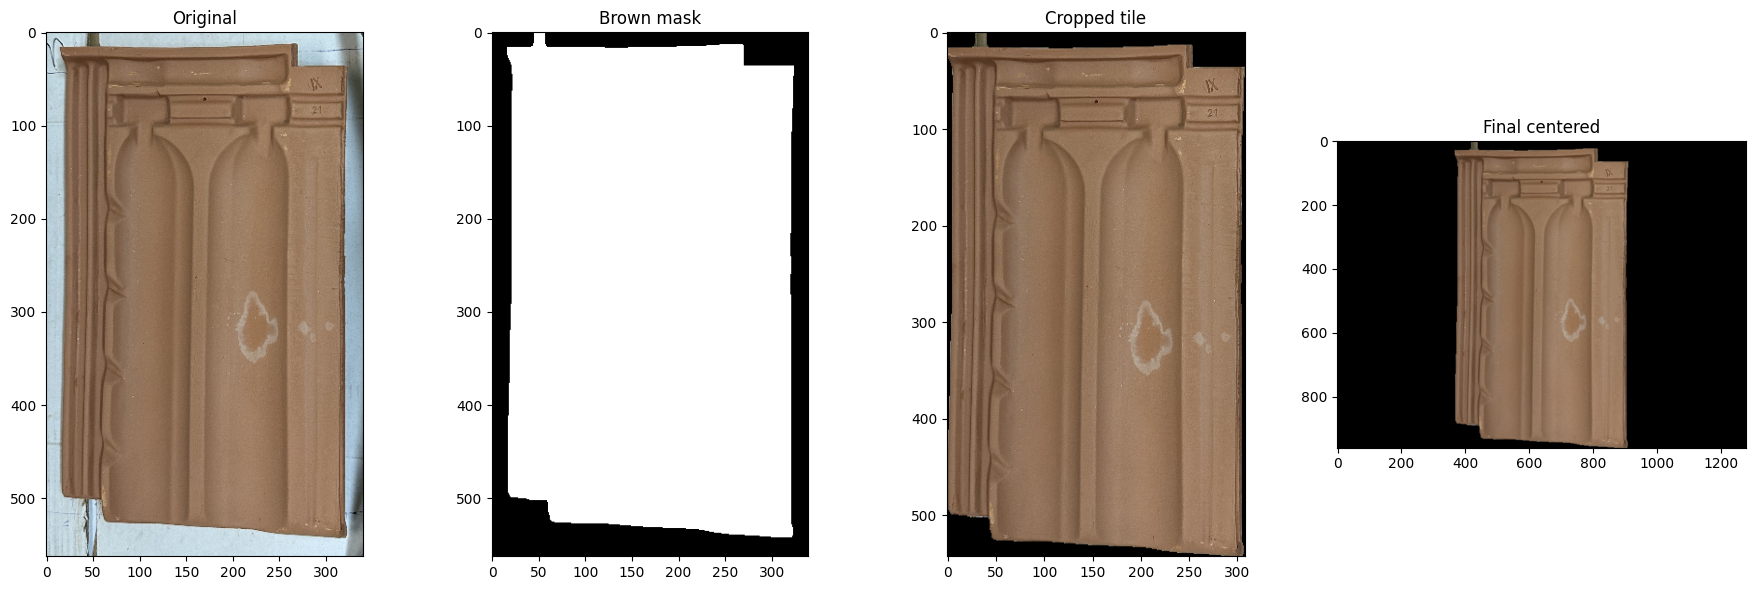

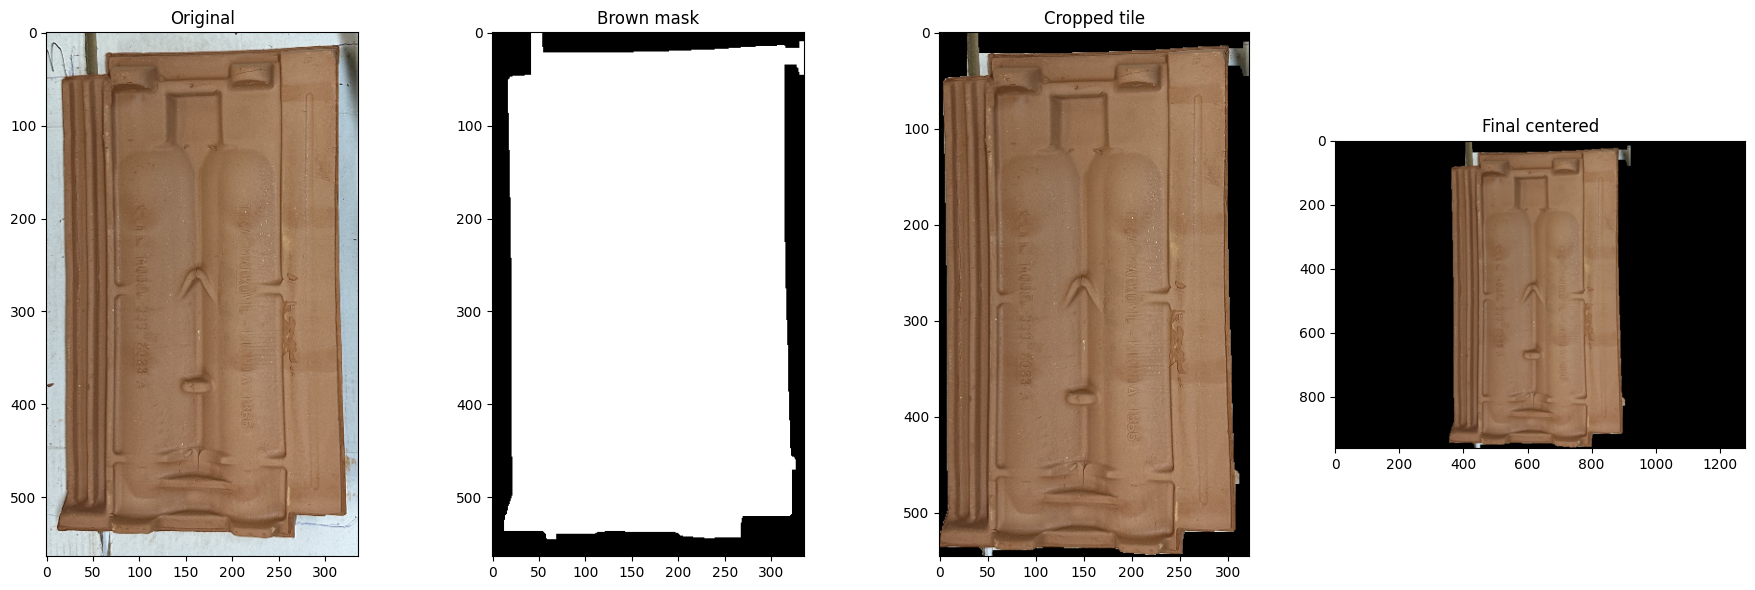

In [3]:
# Proba fje za ekstrakciju i centriranje crepa
image = "./dataset/front/LOM_1_napred_crep_26.png"
output1 = extract_and_center_tile(image,True)

image2 = "./dataset/back/LOM_1_nazad_crep_26.png"
output2 = extract_and_center_tile(image2,True)

imageOK = "./dataset/front/PK_2_napred_crep_106.png"
output1OK = extract_and_center_tile(imageOK,True)

image2OK = "./dataset/back/PK_2_nazad_crep_106.png"
output2OK = extract_and_center_tile(image2OK,True)

    

Učitavanje idealnih slika

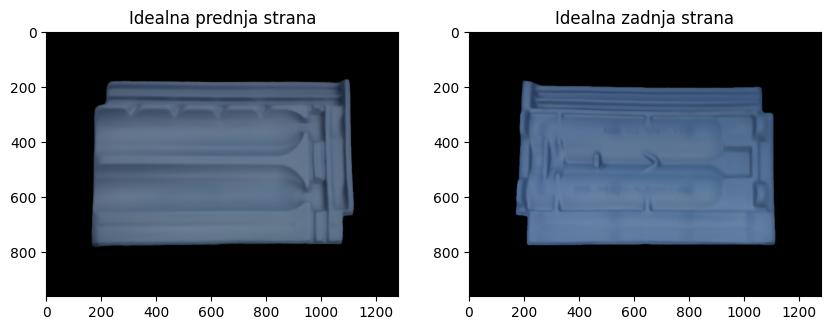

In [4]:
ideal_front = cv2.imread("./base_tiles/tile_front_larger.png")
ideal_back = cv2.imread("./base_tiles/tile_back_larger.png")


# Prikaz
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(ideal_front), plt.title('Idealna prednja strana')
plt.subplot(122), plt.imshow(ideal_back), plt.title('Idealna zadnja strana')
plt.show()

Pomoćna fja pronalaženja parova crepova

In [8]:
def find_tile_pairs(front_dir, back_dir):
    # Pronalazi sve PNG fajlove u direktorijumima za prednju i zadnju stranu
    front_files = [f for f in os.listdir(front_dir) if f.endswith('.png')]
    back_files = [f for f in os.listdir(back_dir) if f.endswith('.png')]

    # Inicijalizuje listu za parove i skup za ID-ove crepova
    pairs = []
    tile_ids = set()

    # Izvlači ID-ove crepova iz imena fajlova prednje strane
    for f in front_files:
        match = re.search(r'crep_(\d+)\.png$', f)
        if match:
            tile_ids.add(match.group(1))

    # Pronalazi parove (prednja i zadnja strana) za svaki ID crepa
    for tid in tile_ids:
        # Filtrira fajlove za prednju stranu koji sadrže 'napred' i odgovarajući ID
        front = [f for f in front_files if f.endswith(f'crep_{tid}.png') and 'napred' in f]
        # Filtrira fajlove za zadnju stranu koji sadrže 'nazad' i odgovarajući ID
        back = [f for f in back_files if f.endswith(f'crep_{tid}.png') and 'nazad' in f]

        # Ako postoje i prednja i zadnja strana, dodaje par u listu
        if front and back:
            pairs.append((tid, front[0], back[0]))  # Par: (ID, prednja slika, zadnja slika)
        else:
            print(f"Upozorenje: Nedostaje par za crep {tid}")

    # Vraća listu pronađenih parova
    return pairs

In [6]:
# Proba fje za pronalaženje parova
tile_pairs = find_tile_pairs("./dataset/front", "./dataset/back")
print(f"Pronađeno {len(tile_pairs)} parova crepova")

Pronađeno 30 parova crepova


Glavna logika


In [9]:
def export_results_to_csv(klasifikovani, output_csv="rez_v2.csv"):
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['ID', 'Front Image', 'Back Image', 'Status', 'Front Matches', 'Back Matches', 'Front SSIM', 'Back SSIM'])
        for r in klasifikovani:
            writer.writerow(r)

    pk_count = sum(1 for r in klasifikovani if r[3] == "PK")
    lom_count = sum(1 for r in klasifikovani if r[3] == "LOM")

    print("\n--- Raspodela klasa ---")
    print(f"PK: {pk_count}")
    print(f"LOM: {lom_count}")

In [13]:
# Funkcija za poravnavanje slike crepa sa referentnom slikom
def align_images(image, reference):
    # Konvertovanje u grayscale za ORB
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_ref = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)
    
    # Pronalaženje ključnih tačaka i deskriptora pomoću ORB
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(gray_img, None) # drugi parametar maska - gde da trazi
    kp2, des2 = orb.detectAndCompute(gray_ref, None)
    
    # Uparivanje deskriptora koristeći BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Ako ima dovoljno podudaranja, primeni homografiju
    if len(matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        # Pronalaženje i primena homografije za poravnavanje
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        aligned = cv2.warpPerspective(image, H, (reference.shape[1], reference.shape[0]))
        return aligned
    return image  # Vraća originalnu sliku ako nema dovoljno podudaranja

# Funkcija za izračunavanje površine crepa
def get_area(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)  # Binarizacija slike
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        return cv2.contourArea(max(contours, key=cv2.contourArea))  # Površina najveće konture
    return 0

# Funkcija za SSIM upoređivanje slika
def compare_ssim_images(image1, image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    ssim_index, _ = compare_ssim(gray1, gray2, full=True)  # Izračunavanje SSIM indeksa
    return ssim_index

# Funkcija za upoređivanje idealnog i testnog crepa
def compare_tiles(ideal_img, test_img, debug=False):
    ideal_gray = cv2.cvtColor(ideal_img, cv2.COLOR_BGR2GRAY)
    test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    
    # ORB detekcija sa većim brojem ključnih tačaka
    orb = cv2.ORB_create(nfeatures=6000)
    kp1, des1 = orb.detectAndCompute(ideal_gray, None)
    kp2, des2 = orb.detectAndCompute(test_gray, None)

    # Provera validnosti deskriptora i uparivanje
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    if des1 is None or des2 is None:
        print("Nema dovoljno deskriptora za upoređivanje.")
        return 0, [], 0.0

    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Dodavanje SSIM vrednosti za upoređivanje
    ssim_value = compare_ssim_images(ideal_img, test_img)

    return len(matches), matches, ssim_value

In [14]:
def classify_all(front_dir, back_dir, ideal_front, ideal_back, threshold=60):
    pairs = find_tile_pairs(front_dir, back_dir)
    rezultati = []

    # Izračunaj površinu idealnih slika jednom
    ideal_area_front = get_area(ideal_front)
    ideal_area_back = get_area(ideal_back)

    for tid, front_name, back_name in pairs:
        front_img = cv2.imread(os.path.join(front_dir, front_name))
        back_img = cv2.imread(os.path.join(back_dir, back_name))
        
        output1 = extract_and_center_tile(front_img, False)
        output2 = extract_and_center_tile(back_img, False)
        
        # Poravnanje sa idealnim slikama
        aligned_front = align_images(output1, ideal_front)
        aligned_back = align_images(output2, ideal_back)

        # Provera površine
        test_area_front = get_area(aligned_front)
        test_area_back = get_area(aligned_back)

        size_ok_front = abs(test_area_front - ideal_area_front) / ideal_area_front < 0.2
        size_ok_back = abs(test_area_back - ideal_area_back) / ideal_area_back < 0.2

        # Upoređivanje ključnih tačaka
        num_matches_front, _, ssim_front = compare_tiles(ideal_front, aligned_front)
        num_matches_back, _, ssim_back = compare_tiles(ideal_back, aligned_back)

        # Kombinovana klasifikacija
        if (num_matches_front <= threshold or not size_ok_front or ssim_front < 0.7) and (num_matches_back <= threshold or not size_ok_back or ssim_back < 0.7):
            status = "LOM"
        else:
            status = "PK"
        
        rezultati.append((tid, front_name, back_name, status, num_matches_front, num_matches_back, ssim_front, ssim_back))

    # Pozivanje funkcije za export rezultata u CSV sa novim fajlom
    export_results_to_csv(rezultati, output_csv="rez_v1.csv")

    return rezultati


In [15]:

results_regular = classify_all(
    front_dir='./dataset/front',
    back_dir='./dataset/back',
    ideal_front=cv2.imread('./base_tiles/tile_front_larger.png'),
    ideal_back=cv2.imread('./base_tiles/tile_back_larger.png')
)



--- Raspodela klasa ---
PK: 20
LOM: 10


In [11]:
# Funkcija za klasifikaciju crepova koristeći KMeans klasterisanje
def classify_with_kmeans(results):
    # Priprema podataka za klasterisanje
    X = []
    for r in results:
        nf, nb, sf, sb = r[3], r[4], r[5], r[6]  # Broj podudaranja i SSIM vrednosti za prednju i zadnju stranu
        X.append([nf, nb, sf, sb])  # Kreiranje vektora karakteristika

    X = np.array(X)  # Konverzija u NumPy niz
    
    # Normalizacija podataka za bolje klasterisanje
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # Standardizacija podataka (srednja vrednost=0, varijansa=1)
    
    # Primena KMeans sa 2 klastera
    kmeans = KMeans(n_clusters=2, random_state=42).fit(X_scaled)
    labels = kmeans.labels_  # Dodeljeni klasteri (0 ili 1)

    # Određivanje "PK" (pogodan) klastera kao brojnijeg
    pk_label = np.argmax(np.bincount(labels))  # Klaster sa više elemenata je "PK"

    # Dodela oznaka "PK" ili "LOM" svakom crepu
    klasifikovani = []
    for i, r in enumerate(results):
        tid, front, back = r[0], r[1], r[2]  # ID crepa, imena prednje i zadnje slike
        label = "PK" if labels[i] == pk_label else "LOM"  # "PK" za brojniji klaster, "LOM" za ostale
        klasifikovani.append((tid, front, back, label, *r[3:]))  # Čuvanje svih podataka sa oznakom
    
    return klasifikovani  # Vraća listu sa klasifikovanim crepovima

# Funkcija za obradu i pripremu podataka za klasifikaciju svih crepova
def classify_all_kmeans(front_dir, back_dir, ideal_front, ideal_back):
    # Pronalaženje parova slika (prednja i zadnja strana crepa)
    pairs = find_tile_pairs(front_dir, back_dir)
    rezultati = []

    # Izračunavanje površine idealnih slika
    ideal_area_front = get_area(ideal_front)
    ideal_area_back = get_area(ideal_back)

    # Obrada svakog para slika crepa
    for tid, front_name, back_name in pairs:
        # Učitavanje slika prednje i zadnje strane
        front_img = cv2.imread(os.path.join(front_dir, front_name))
        back_img = cv2.imread(os.path.join(back_dir, back_name))
        
        # Ekstrakcija i centriranje crepa na slikama
        output1 = extract_and_center_tile(front_img, False)
        output2 = extract_and_center_tile(back_img, False)
        
        # Poravnavanje slika sa idealnim slikama
        aligned_front = align_images(output1, ideal_front)
        aligned_back = align_images(output2, ideal_back)

        # Izračunavanje površine poravnatih slika
        test_area_front = get_area(aligned_front)
        test_area_back = get_area(aligned_back)

        # Upoređivanje slika koristeći ORB i SSIM
        num_matches_front, _, ssim_front = compare_tiles(ideal_front, aligned_front)
        num_matches_back, _, ssim_back = compare_tiles(ideal_back, aligned_back)

        # Čuvanje rezultata za trenutni crep
        rezultati.append((tid, front_name, back_name, num_matches_front, num_matches_back, ssim_front, ssim_back))

    return rezultati  # Vraća listu rezultata za sve crepove

In [15]:

results_kmeans = classify_all_kmeans(
    front_dir='./dataset/front',
    back_dir='./dataset/back',
    ideal_front=cv2.imread('./base_tiles/tile_front_larger.png'),
    ideal_back=cv2.imread('./base_tiles/tile_back_larger.png')
)

final_results_kmeans = classify_with_kmeans(results_kmeans)
export_results_to_csv(final_results_kmeans)


--- Raspodela klasa ---
PK: 21
LOM: 9



--- Metrike (Regularna) ---
True Positives (TP): 18
False Positives (FP): 2
True Negatives (TN): 8
False Negatives (FN): 2
Preciznost: 0.90
Pouzdanost: 0.90
F1-score: 0.90

--- Metrike (KMeans) ---
True Positives (TP): 19
False Positives (FP): 2
True Negatives (TN): 8
False Negatives (FN): 1
Preciznost: 0.90
Pouzdanost: 0.95
F1-score: 0.93

--- Pregled tačnosti (Regularna) ---
Tačno
True     26
False     4
Name: count, dtype: int64

 Tačnost modela (Regularna): 86.67%

--- Pregled tačnosti (KMeans) ---
Tačno
True     27
False     3
Name: count, dtype: int64

 Tačnost modela (KMeans): 90.00%


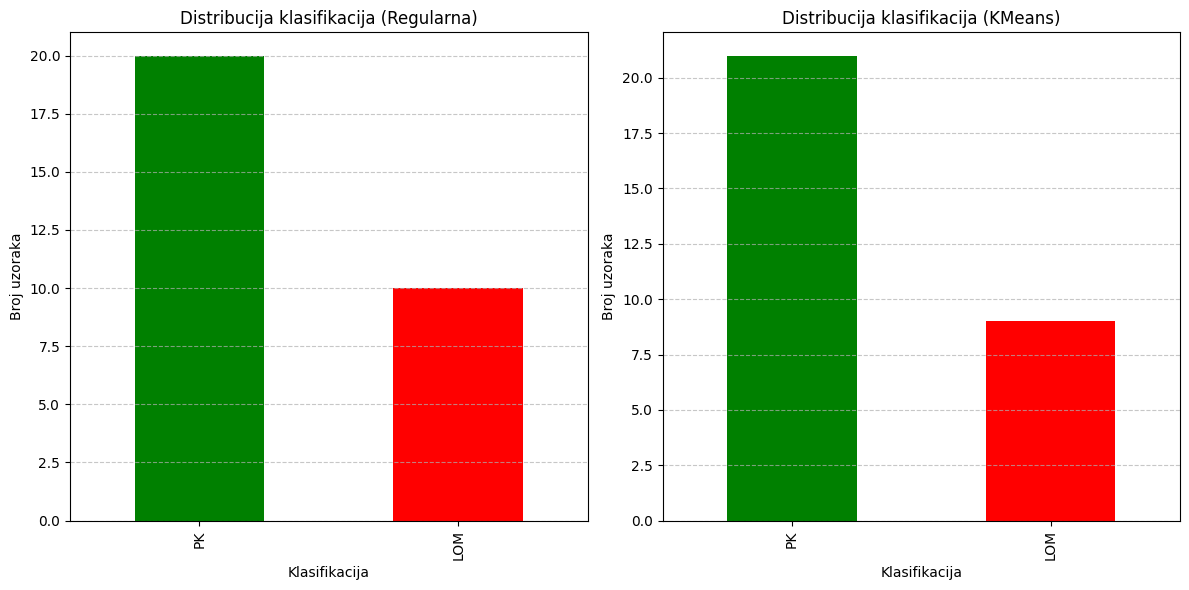

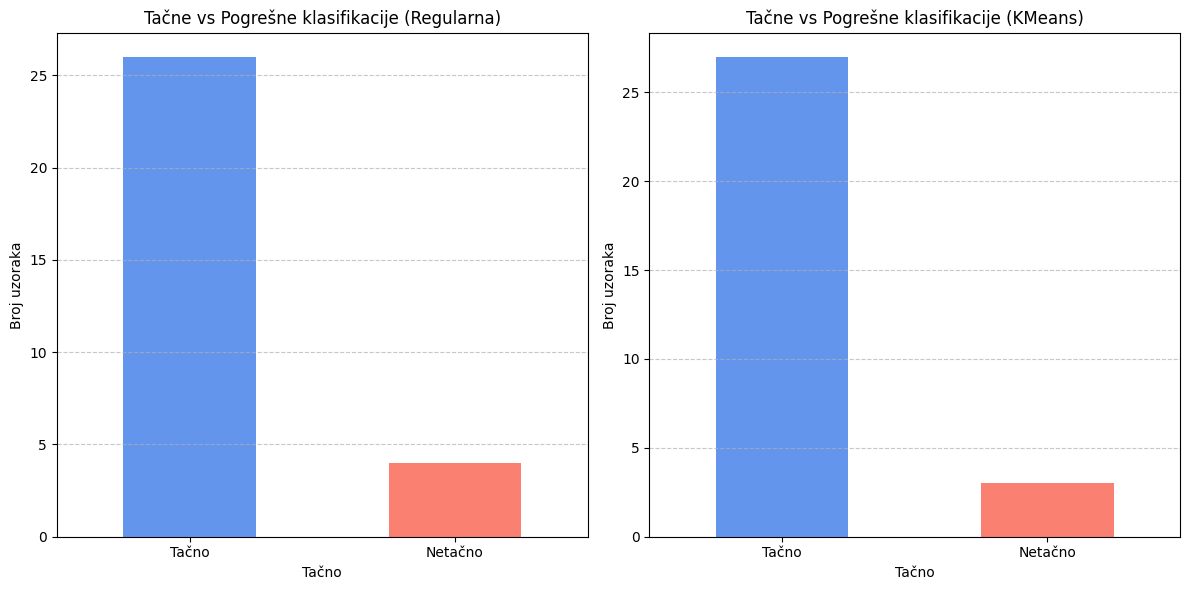


--- Uporedna tačnost ---
Tačnost (Regularna): 86.67%
Tačnost (KMeans): 90.00%
Razlika u tačnosti: 3.33%


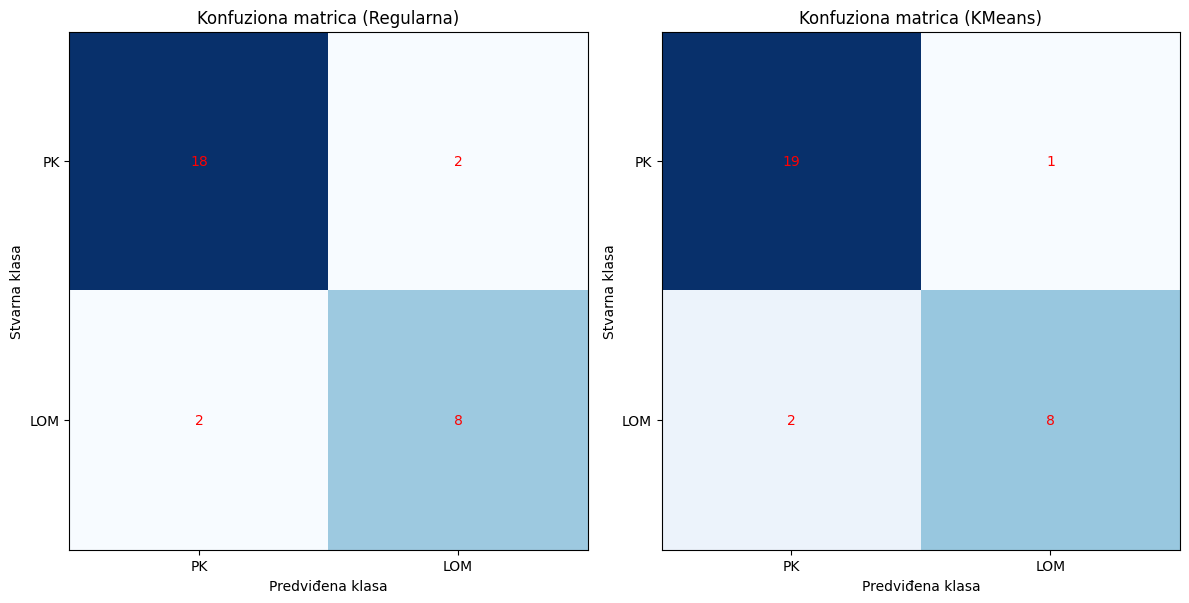

In [16]:
# Evaluacija 

# Pretvaranje u DataFrame za analizu oba pristupa
df_regular = pd.DataFrame(
    results_regular,
    columns=[
        'ID',
        'Front Image',
        'Back Image',
        'Status',
        'Front Matches',
        'Back Matches',
        'Front SSIM',
        'Back SSIM'
    ]
)

df_kmeans = pd.DataFrame(
    final_results_kmeans,
    columns=[
        'ID',
        'Front Image',
        'Back Image',
        'Status',
        'Front Matches',
        'Back Matches',
        'Front SSIM',
        'Back SSIM'
    ]
)

# Izvlačenje ground truth iz imena fajlova
df_regular["Ground Truth"] = df_regular["Front Image"].apply(lambda x: "PK" if "PK" in x.upper() else "LOM")
df_kmeans["Ground Truth"] = df_kmeans["Front Image"].apply(lambda x: "PK" if "PK" in x.upper() else "LOM")

# Da li je klasifikacija tačna za oba pristupa
df_regular["Tačno"] = df_regular["Status"] == df_regular["Ground Truth"]
df_kmeans["Tačno"] = df_kmeans["Status"] == df_kmeans["Ground Truth"]

# Funkcija za izračunavanje osnovnih metrika
def calculate_metrics(df):
    tp = len(df[(df["Status"] == "PK") & (df["Ground Truth"] == "PK")])  # True Positive (PK)
    fp = len(df[(df["Status"] == "PK") & (df["Ground Truth"] == "LOM")])  # False Positive (PK)
    tn = len(df[(df["Status"] == "LOM") & (df["Ground Truth"] == "LOM")])  # True Negative (LOM)
    fn = len(df[(df["Status"] == "LOM") & (df["Ground Truth"] == "PK")])  # False Negative (LOM)
    
    precision = precision_score(df["Ground Truth"], df["Status"], pos_label="PK")
    recall = recall_score(df["Ground Truth"], df["Status"], pos_label="PK")
    f1 = f1_score(df["Ground Truth"], df["Status"], pos_label="PK")

    return tp, fp, tn, fn, precision, recall, f1

# Izračunavanje metrika za oba pristupa
tp_regular, fp_regular, tn_regular, fn_regular, precision_regular, recall_regular, f1_regular = calculate_metrics(df_regular)
tp_kmeans, fp_kmeans, tn_kmeans, fn_kmeans, precision_kmeans, recall_kmeans, f1_kmeans = calculate_metrics(df_kmeans)

# Ispis metrika
print("\n--- Metrike (Regularna) ---")
print(f"True Positives (TP): {tp_regular}")
print(f"False Positives (FP): {fp_regular}")
print(f"True Negatives (TN): {tn_regular}")
print(f"False Negatives (FN): {fn_regular}")
print(f"Preciznost: {precision_regular:.2f}")
print(f"Pouzdanost: {recall_regular:.2f}")
print(f"F1-score: {f1_regular:.2f}")

print("\n--- Metrike (KMeans) ---")
print(f"True Positives (TP): {tp_kmeans}")
print(f"False Positives (FP): {fp_kmeans}")
print(f"True Negatives (TN): {tn_kmeans}")
print(f"False Negatives (FN): {fn_kmeans}")
print(f"Preciznost: {precision_kmeans:.2f}")
print(f"Pouzdanost: {recall_kmeans:.2f}")
print(f"F1-score: {f1_kmeans:.2f}")

# Sumarni pregled tačnosti za oba pristupa
print("\n--- Pregled tačnosti (Regularna) ---")
print(df_regular["Tačno"].value_counts())
print(f"\n Tačnost modela (Regularna): {df_regular['Tačno'].mean() * 100:.2f}%")

print("\n--- Pregled tačnosti (KMeans) ---")
print(df_kmeans["Tačno"].value_counts())
print(f"\n Tačnost modela (KMeans): {df_kmeans['Tačno'].mean() * 100:.2f}%")

# Vizuelizacija klasifikacija (PK vs LOM) za oba pristupa
plt.figure(figsize=(12, 6))

# Regularni pristup
plt.subplot(1, 2, 1)
df_regular["Status"].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Distribucija klasifikacija (Regularna)")
plt.ylabel("Broj uzoraka")
plt.xlabel("Klasifikacija")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# KMeans pristup
plt.subplot(1, 2, 2)
df_kmeans["Status"].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Distribucija klasifikacija (KMeans)")
plt.ylabel("Broj uzoraka")
plt.xlabel("Klasifikacija")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Vizuelizacija tačnih i pogrešnih klasifikacija za oba pristupa
plt.figure(figsize=(12, 6))

# Regularni pristup
plt.subplot(1, 2, 1)
df_regular["Tačno"].value_counts().plot(kind='bar', color=['cornflowerblue', 'salmon'])
plt.title("Tačne vs Pogrešne klasifikacije (Regularna)")
plt.xticks([0, 1], ['Tačno', 'Netačno'], rotation=0)
plt.ylabel("Broj uzoraka")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# KMeans pristup
plt.subplot(1, 2, 2)
df_kmeans["Tačno"].value_counts().plot(kind='bar', color=['cornflowerblue', 'salmon'])
plt.title("Tačne vs Pogrešne klasifikacije (KMeans)")
plt.xticks([0, 1], ['Tačno', 'Netačno'], rotation=0)
plt.ylabel("Broj uzoraka")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Upoređivanje tačnosti oba pristupa
accuracy_regular = df_regular['Tačno'].mean() * 100
accuracy_kmeans = df_kmeans['Tačno'].mean() * 100

print(f"\n--- Uporedna tačnost ---")
print(f"Tačnost (Regularna): {accuracy_regular:.2f}%")
print(f"Tačnost (KMeans): {accuracy_kmeans:.2f}%")
print(f"Razlika u tačnosti: {accuracy_kmeans - accuracy_regular:.2f}%")

# Vizualizacija konfuzionih matrica za oba pristupa
conf_matrix_regular = confusion_matrix(df_regular["Ground Truth"], df_regular["Status"], labels=["PK", "LOM"])
conf_matrix_kmeans = confusion_matrix(df_kmeans["Ground Truth"], df_kmeans["Status"], labels=["PK", "LOM"])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Regularni pristup
axs[0].imshow(conf_matrix_regular, interpolation='nearest', cmap=plt.cm.Blues)
axs[0].set_title("Konfuziona matrica (Regularna)")
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(["PK", "LOM"])
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["PK", "LOM"])
axs[0].set_ylabel('Stvarna klasa')
axs[0].set_xlabel('Predviđena klasa')
for i in range(2):
    for j in range(2):
        axs[0].text(j, i, format(conf_matrix_regular[i, j], 'd'),
                    ha="center", va="center", color="red")
        
# KMeans pristup
axs[1].imshow(conf_matrix_kmeans, interpolation='nearest', cmap=plt.cm.Blues)
axs[1].set_title("Konfuziona matrica (KMeans)")
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(["PK", "LOM"])
axs[1].set_yticks([0, 1])
axs[1].set_yticklabels(["PK", "LOM"])
axs[1].set_ylabel('Stvarna klasa')
axs[1].set_xlabel('Predviđena klasa')
for i in range(2):
    for j in range(2):
        axs[1].text(j, i, format(conf_matrix_kmeans[i, j], 'd'),
                    ha="center", va="center", color="red")

plt.tight_layout()
plt.show()


In [17]:
# Mene zanimalo :)

def plot_kmeans_clusters(klasifikovani, output_file="kmeans_clusters.png"):
    # Priprema pod
    data = {
        'SSIM_Front': [r[6] for r in klasifikovani],
        'SSIM_Back': [r[7] for r in klasifikovani],
        'Matches_Front': [r[4] for r in klasifikovani],
        'Matches_Back': [r[5] for r in klasifikovani],
        'Class': [r[3] for r in klasifikovani]
    }
    df = pd.DataFrame(data)

    sns.set_theme(style="ticks", font_scale=1.2)
    pair_plot = sns.pairplot(
        df,
        hue='Class',
        palette={'PK': 'blue', 'LOM': 'red'},
        diag_kind='hist',
        diag_kws={'bins': 20, 'alpha': 0.5},
        plot_kws={'s': 100, 'alpha': 0.6, 'edgecolor': 'white'}
    )

    pair_plot.figure.suptitle('K-Means Clustering of Tiles (PK vs LOM)', y=1.02, fontsize=16)
    for ax in pair_plot.axes.flatten():
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlabel(ax.get_xlabel(), fontsize=10)
        ax.set_ylabel(ax.get_ylabel(), fontsize=10)

    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"Plot saved to {output_file}")

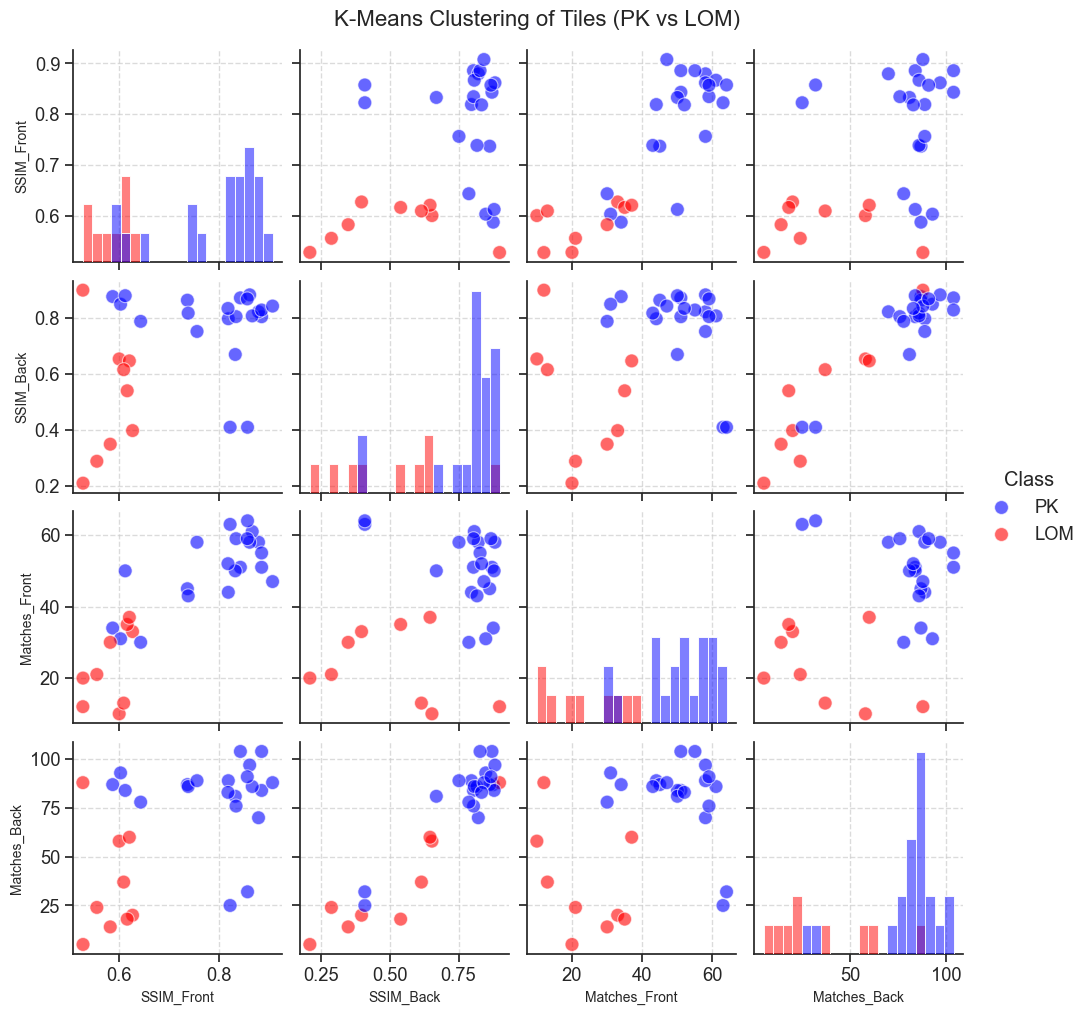

Plot saved to kmeans_clusters.png


In [18]:
plot_kmeans_clusters(final_results_kmeans)